In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import geoplot
import geoplot.crs as gcrs
from shapely.geometry import Point

In [4]:
grand_lyon = {69033, 69040, 69046, 69063, 69068, 69069, 69071, 69085, 69087, 69088, 69096, 69116, 69117, 69127, 69143, 69153, 69205, 69207, 69233, 69250, 69260, 69284, 69292, 69293, 69296, 69286, 69089, 69204, 69244, 69283, 69149, 69091, 69256, 69034, 69282, 69259, 69290, 69266, 69081, 69029, 69123, 69275, 69100, 69278, 69044, 69279, 69152, 69271, 69072, 69276, 69273, 69142, 69003, 69163, 69168, 69191, 69194, 69199, 69202, 69389,69385,69383,69387,69382,69386,69384,69388,69381,}


# données carroyés de l'INSEE : https://www.insee.fr/fr/statistiques/6215138?sommaire=6215217
df = pd.read_csv('carreaux_200m_metropole_csv/Filosofi2015_carreaux_200m_metropole.csv')
df = df.loc[df.Depcom.isin(grand_lyon), ["Ind", "IdINSPIRE", "Depcom", "I_est_cr"]].reset_index(drop=True)
df

/tmp/ipykernel_3145963/2081933027.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('carreaux_200m_metropole_csv/Filosofi2015_carreaux_200m_metropole.csv')


Ind                       IdINSPIRE Depcom  I_est_cr
0       2.0  CRS3035RES200mN2529000E3917400  69142         1
1     135.0  CRS3035RES200mN2534400E3919800  69034         0
2       9.0  CRS3035RES200mN2541800E3920000  69085         1
3     224.0  CRS3035RES200mN2520800E3923000  69273         0
4     330.5  CRS3035RES200mN2522400E3917600  69100         0
...     ...                             ...    ...       ...
7921  221.5  CRS3035RES200mN2534000E3919800  69034         0
7922   84.0  CRS3035RES200mN2535200E3923200  69286         0
7923   16.0  CRS3035RES200mN2533200E3920000  69034         1
7924    7.0  CRS3035RES200mN2537800E3912600  69072         1
7925    9.0  CRS3035RES200mN2537800E3914800  69116         1

[7926 rows x 4 columns]

In [5]:
import re
from shapely.geometry import Polygon

def convert_carreaux(carreaux):
    # Extract IdINSPIRE as strings
    id_inspire = carreaux['IdINSPIRE']
    
    # Extract EPSG code from first row
    epsg = int(re.search(r'CRS(\d+)', id_inspire.iloc[0]).group(1))
    
    # Extract dimensions and coordinates using list comprehension
    taille_carreaux = [int(re.search(r'RES(\d+)', x).group(1)) for x in id_inspire]
    ordonnees_carreaux = [int(re.search(r'N(\d+)', x).group(1)) for x in id_inspire]
    abscisses_carreaux = [int(re.search(r'E(\d+)', x).group(1)) for x in id_inspire]
    
    # Create geometries (polygons)
    geometries = [
        Polygon([
            (x, y),
            (x + taille, y),
            (x + taille, y + taille),
            (x, y + taille),
            (x, y)
        ]) for x, y, taille in zip(abscisses_carreaux, ordonnees_carreaux, taille_carreaux)
    ]
    
    # Convert to GeoDataFrame
    carreaux_gdf = gpd.GeoDataFrame(
        carreaux,
        geometry=geometries,
        crs=f"EPSG:{epsg}"
    )
    
    # Add coordinates columns
    # carreaux_gdf['x'] = abscisses_carreaux
    # carreaux_gdf['y'] = ordonnees_carreaux
    return carreaux_gdf

gdf = convert_carreaux(df).set_crs(epsg=3035)
gdf

Ind                       IdINSPIRE Depcom  I_est_cr  \
0       2.0  CRS3035RES200mN2529000E3917400  69142         1   
1     135.0  CRS3035RES200mN2534400E3919800  69034         0   
2       9.0  CRS3035RES200mN2541800E3920000  69085         1   
3     224.0  CRS3035RES200mN2520800E3923000  69273         0   
4     330.5  CRS3035RES200mN2522400E3917600  69100         0   
...     ...                             ...    ...       ...   
7921  221.5  CRS3035RES200mN2534000E3919800  69034         0   
7922   84.0  CRS3035RES200mN2535200E3923200  69286         0   
7923   16.0  CRS3035RES200mN2533200E3920000  69034         1   
7924    7.0  CRS3035RES200mN2537800E3912600  69072         1   
7925    9.0  CRS3035RES200mN2537800E3914800  69116         1   

                                               geometry  
0     POLYGON ((3917400 2529000, 3917600 2529000, 39...  
1     POLYGON ((3919800 2534400, 3920000 2534400, 39...  
2     POLYGON ((3920000 2541800, 3920200 2541800, 39...  
3     POLYGON ((3923000 2520800, 3923200 2520800, 39...  
4     POLYGON ((3917600 2522400, 3917800 2522400, 39...  
...                                                 ...  
7921  POLYGON ((3919800 2534000, 3920000 2534000, 39...  
7922  POLYGON ((3923200 2535200, 3923400 2535200, 39...  
7923  POLYGON ((3920000 2533200, 3920200 2533200, 39...  
7924  POLYGON ((3912600 2537800, 3912800 2537800, 39...  
7925  POLYGON ((3914800 2537800, 3915000 2537800, 39...  

[7926 rows x 5 columns]

In [7]:
x = gdf.geometry.centroid.x
y = gdf.geometry.centroid.y

barycenter = Point((np.array([x, y]) * gdf.Ind.values).sum(axis=1) / gdf.Ind.sum())
barycenter_gdf = gpd.GeoDataFrame(geometry=[barycenter], crs="EPSG:3035").to_crs("EPSG:4326")
lon, lat = barycenter_gdf.geometry.iloc[0].coords.xy
print(f"The inhabitants weighted barycenter of Lyon is : {lat[0]:.6f}N, {lon[0]:.6f}E")

The inhabitants weighted barycenter of Lyon is : 45.752330N, 4.856850E


## Résultat

Le barycentre des habitants de lyon est au : **45.752330N, 4.856850**.

C'est au jardin Jacob Kaplan, dans le 3ème. 

In [45]:
# # Convert coordinate system
# # First set the initial CRS if not already set
# gdf = gdf.set_crs(epsg=3035)

# # Transform to WGS84 (lat/lon)
# gdf = gdf.to_crs(epsg=4326)
# gdf

<GeoAxes: >

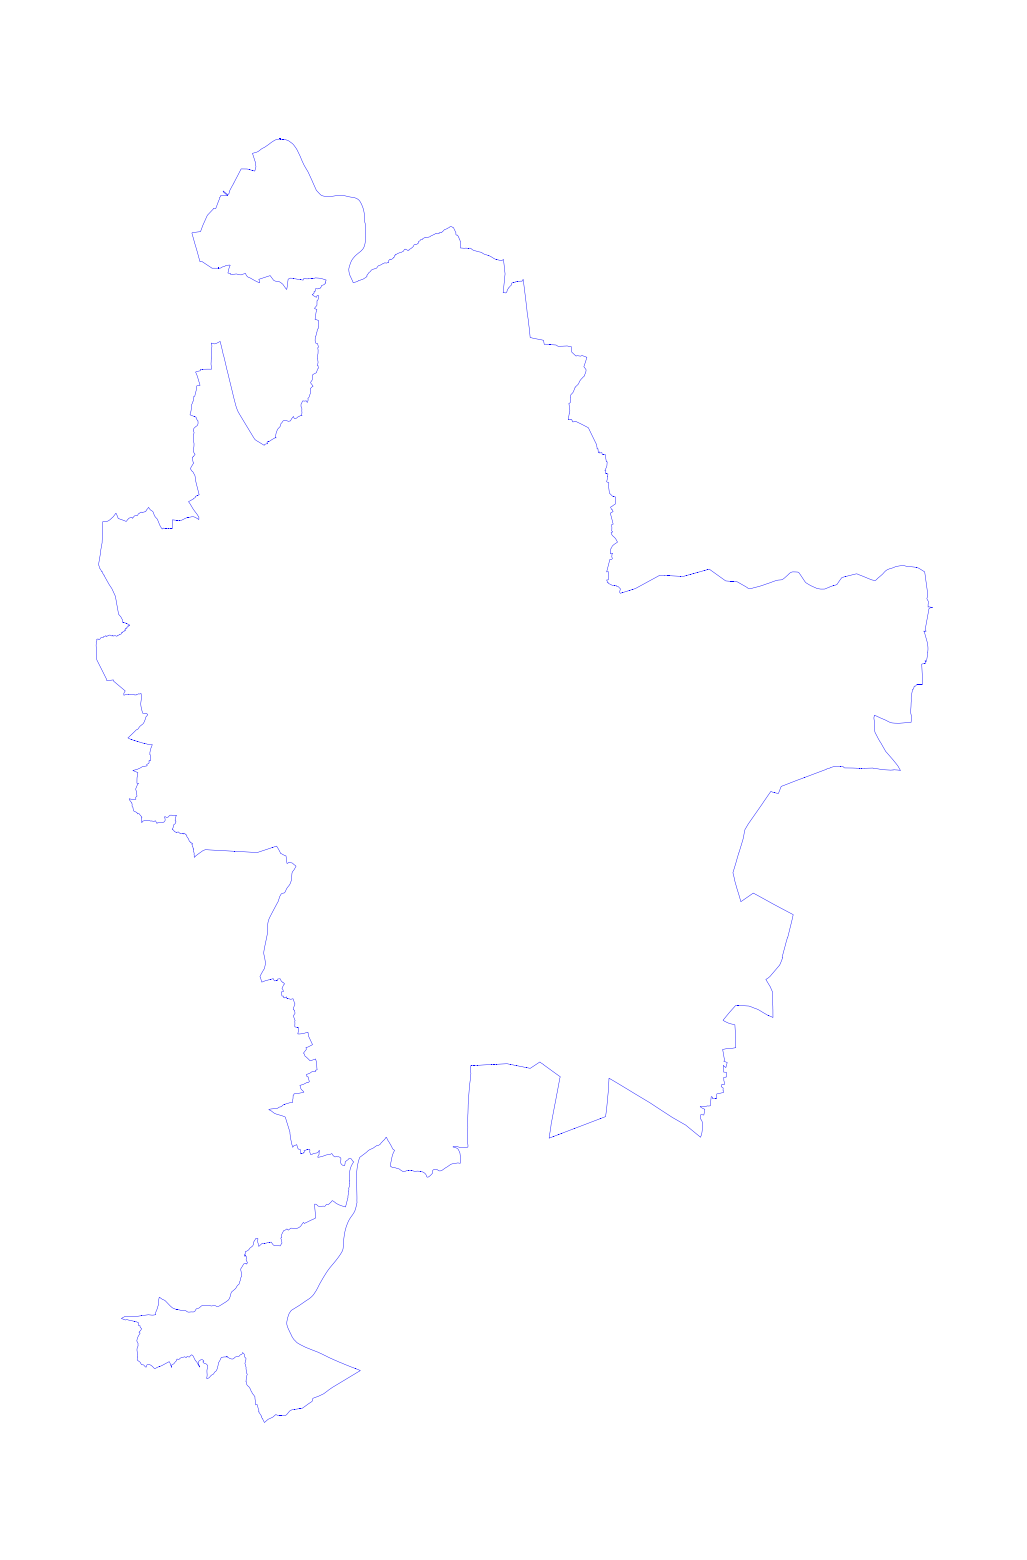

In [6]:
shapes = gpd.read_file("adr_voie_lieu/adr_voie_lieu.adrmetropole.shp")

plot = geoplot.polyplot(shapes, projection=gcrs.AlbersEqualArea(), edgecolor='blue', facecolor='white', linewidth=.3,
    figsize=(20, 20))
plot